In [3]:
from copyreg import pickle
import os
import gc
import tqdm
import pickle
import pandas as pd
import numpy as np
import random
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from termcolor import colored

In [3]:
# import pandas as pd
train = pd.read_csv('../data/transactions_train.csv.zip',date_parser='t_dat')
train['t_dat'] = pd.to_datetime(train['t_dat'])

#For Memory optimization
train['customer_id'] = train['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
train['article_id'] = train.article_id.astype('int32')

print(train.customer_id.nunique())
print(f'date_range: {train.t_dat.min()} - {train.t_dat.max()}')
display(train.describe())
train.shape

1362281
date_range: 2018-09-20 00:00:00 - 2020-09-22 00:00:00


,customer_id,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07,3.178832e+07
mean,2.791867e+15,6.962272e+08,2.782927e-02,1.704028e+00
std,5.327581e+18,1.334480e+08,1.918113e-02,4.564786e-01
min,-9.223353e+18,1.087750e+08,1.694915e-05,1.000000e+00
25%,-4.613999e+18,6.328030e+08,1.581356e-02,1.000000e+00
50%,6.982095e+15,7.145820e+08,2.540678e-02,2.000000e+00
75%,4.617979e+18,7.865240e+08,3.388136e-02,2.000000e+00
max,9.223371e+18,9.562170e+08,5.915254e-01,2.000000e+00


(31788324, 5)

#### Merge with article data

In [5]:
products = pd.read_csv('../data/articles.csv.zip')
print(f'unique products {products.product_code.nunique()}')
print(f'unique articles {products.article_id.nunique()}')
print(f'unique product_type {products.product_type_no.nunique()}')
print(f'unique product_group {products.product_group_name.nunique()}')
products_col = ['article_id','product_code','prod_name','product_type_no','product_type_name', 'product_group_name']
df = pd.merge(train[['t_dat','customer_id','article_id']],products[products_col],on=['article_id'],how='left')
df['order_instance'] = df['customer_id'].astype(str) + df['t_dat'].astype(str)
print(f'unique_orders_instance {df.order_instance.nunique()}')
df.head()

unique products 47224
unique articles 105542
unique product_type 132
unique product_group 19
unique_orders_instance 9080179


,t_dat,customer_id,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,order_instance
0,2018-09-20,-6846340800584936,663713001,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,-68463408005849362018-09-20
1,2018-09-20,-6846340800584936,541518023,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,-68463408005849362018-09-20
2,2018-09-20,-8334631767138808638,505221004,505221,Inca Jumper,252,Sweater,Garment Upper body,-83346317671388086382018-09-20
3,2018-09-20,-8334631767138808638,685687003,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,-83346317671388086382018-09-20
4,2018-09-20,-8334631767138808638,685687004,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,-83346317671388086382018-09-20


,counts
706016001,50287
706016002,35043
372860001,31718
610776002,30199
759871002,26329


Text(0, 0.5, 'percentage of articles')

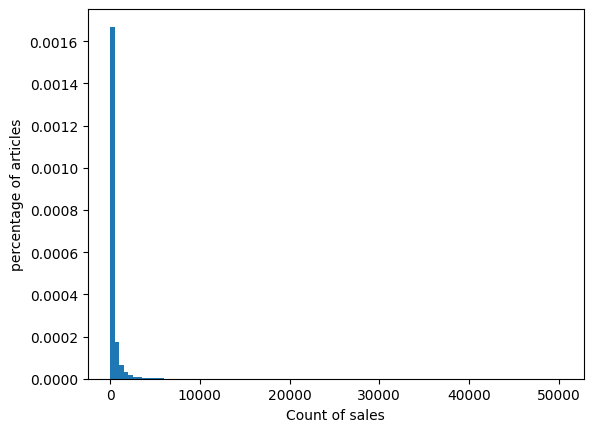

In [351]:
cnt = pd.DataFrame(df.article_id.value_counts())
cnt = pd.DataFrame(cnt)
cnt.columns = ['counts']
display(cnt.head())
plt.hist(cnt.counts.values,density=True,bins=100)
plt.xlabel('Count of sales')
plt.ylabel('percentage of articles')

### Long tail pattern

- A) Most of the articles sold only a few times

### Report Design for Items Frequently and Rarely sold together

- A) May not be feassible or logical to consider all 105542 articles
- B) Article_id may not be suitable aggregator(eg. Strap top color black vs. Strap top color White as different articles) as multiple articles are too identical have comparable pattern.product_code level or above hierarchy report might be suitable.
- C) Flexibility- In terms of selection of hierarchy,filtering condition,no of Frequently and Rarely sold products(eg. for each item we may report any no of Frequently co-purchased items for any hierarchy) 
- D) Individual vs. All- Based on requirement reports for all products(total no vary based on fitering criteria) or customized for few products. Can be explored a particular product in detail.

#### a) Filtering - based on no of times(eg. min 500 times) each item sold

In [10]:
prod_index_cutoff = cnt[cnt.counts >= 500].index
df1 = df[df.article_id.isin(prod_index_cutoff)]
print(f'unique products {df1.product_code.nunique()}')
print(f'unique articles {df1.article_id.nunique()}')

unique products 7689
unique articles 16953


#### b) Filtering - based on penetration(fraction of unique customer bought). 

Text(0, 0.5, 'percentage of articles')

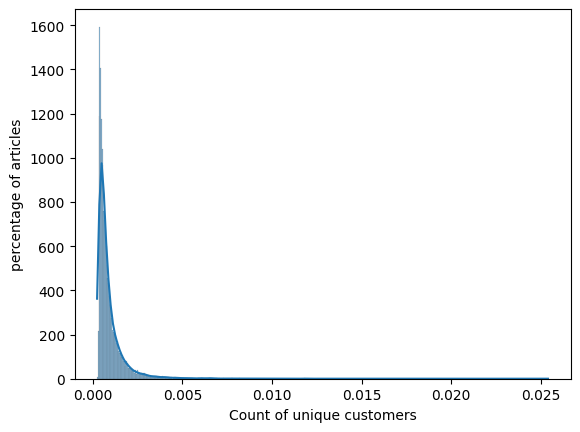

In [29]:
custn = df.groupby('article_id')['customer_id'].nunique()
cust = df['customer_id'].nunique()
custn = custn/cust
sns.histplot(data=custn, kde=True)
plt.xlabel('Count of unique customers')
plt.ylabel('percentage of articles')

#### Most of the articles are bought by to few customers. So with 0.001(0.1%) as customer penetration fraction  

In [32]:
custn = custn.sort_values(ascending=False)
prod_index_cutoff = list(custn[custn >= 0.001].index)
df1 = df[df.article_id.isin(prod_index_cutoff)]
display(df1.head())
print(f'unique products {df1.product_code.nunique()}')
print(f'unique articles {df1.article_id.nunique()}')
print(f'unique_orders_instance {df1.order_instance.nunique()}')
print(f'unique customers: {df1.customer_id.nunique()}')

,t_dat,customer_id,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,order_instance
3,2018-09-20,-8334631767138808638,685687003,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,-83346317671388086382018-09-20
4,2018-09-20,-8334631767138808638,685687004,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,-83346317671388086382018-09-20
5,2018-09-20,-8334631767138808638,685687001,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,-83346317671388086382018-09-20
7,2018-09-20,3618040643253904000,688873012,688873,Gyda!,258,Blouse,Garment Upper body,36180406432539040002018-09-20
11,2018-09-20,3618040643253904000,688873011,688873,Gyda!,258,Blouse,Garment Upper body,36180406432539040002018-09-20


unique products 2135
unique articles 4421
unique_orders_instance 5580293
unique customers: 1120214


### Illustration

#### Data Preparation of all eligible products for reporting

- A) Flexible with Product filtering criteria or minimum order count(for product) 

In [327]:
def data_prep(transaction:pd.DataFrame, products:pd.DataFrame,min_cnt:int=1,penetration:float=0.0):

    """
    Data prep function for further Analytics.

    Args:
        params: 
            transaction: Dataframe of the purchases each customer for each date with article id(additional information). 
            products: detailed product hierarchy metadata for each article_id available for purchase
            min_cnt: minimum order count for eligible article_id
            penetration:Fraction of unique customers for eligible article_id
    Returns:
        order instance wise Merged and filtered Dataframe with eligible article/products.
    """

    transaction['customer_id'] = transaction['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    transaction['article_id'] = transaction.article_id.astype('int32')
    products_col = ['article_id','product_code','prod_name','product_type_no','product_type_name', 'product_group_name']
    df = pd.merge(transaction[['t_dat','customer_id','article_id']],products[products_col],on=['article_id'],how='left')
    cnt = pd.DataFrame(df.article_id.value_counts())
    cnt.columns = ['counts']
    if penetration > 0:
        custn = transaction.groupby('article_id')['customer_id'].nunique()
        cust = transaction['customer_id'].nunique()
        custn = custn/cust
        custn = custn.sort_values(ascending=False)
        prod_index_cutoff = list(custn[custn >= penetration].index)
        df = df[df.article_id.isin(prod_index_cutoff)]
    if min_cnt > 1:
        cnt = transaction.article_id.value_counts()
        prod_index_cutoff = list(cnt[cnt >= min_cnt].index)
        df = df[df.article_id.isin(prod_index_cutoff)]         
    df['order_instance'] = df['customer_id'].astype(str) + df['t_dat']
    return df
df = data_prep(transaction = train,products=products,min_cnt = 100,penetration=0.001)
  

#### Reporting Function

- A)Provides list(length varies based on input desired number n) of frequently and rarely product items w.r.t. queried item at that product_hierarchy
- B) Calculate Basic metrics - Support(for each item) and confidence(item pair wise) scores
- C) For all items(based on filtering condition) or customized list of items  

In [37]:
def prepare_all_products_report(df:pd.DataFrame,product_hierarchy:str,n,all:bool=True,prods:list = []):
    
    """
    Reporting function to generate dataframe of frequently and rarely product combination along with metrics.

    Args:
        params: 
            df: order instance wise Merged and filtered Dataframe with eligible article/products 
            product_hierarchy: product_hierarchy(article/product/product_type/product_group) of reporting
            n: number of often/rarely purchased products for each products
            all: boolean to indicate if report for all items in hierarchy, default is True
            prods:optional list of items for customized report only for these items.To use this all indicator should be False

    Returns:
        a) list(based on n) of frequently/rarely co-purchased items for each item
        along with support for respective item and confidence metrics for each frequently co-purchased items.
        b) support(order count for individual item/total order count) for each item w.r.t. product_hierarchy input
    """
    cnt = df[product_hierarchy].value_counts()
    if not all:
        try:
            cnt = cnt[cnt.index.isin(prods)]
        except:
            raise ValueError('item list is empty')    
    n_order = df['order_instance'].nunique()
    order_cnt = df.groupby([product_hierarchy])['order_instance'].nunique()
    support = order_cnt/n_order
    order_cnt=order_cnt.to_dict()
    
    most_frequent = {}
    most_frequent_cnt = {}
    least_frequent = {}
    item_order_cnt = {}
    item_support = {}
    # leat_frequent_cnt = {}
    for j,i in tqdm(enumerate(cnt.index.values)):
        orders = df.loc[df[product_hierarchy]==i,'order_instance'].unique()
        cnt2 = df.loc[(df.order_instance.isin(orders))&(df[product_hierarchy]!=i),product_hierarchy].value_counts()
        most_frequent[i] = [cnt2.index[j] for j in range(1,n+1)]
        least_frequent[i] = [cnt2.index[j] for j in range(-1,-(n+1),-1)]
        most_frequent_cnt[i] = [cnt2.values[j] for j in range(1,n+1)]
        item_order_cnt[i] = order_cnt[i]
        item_support[i] = support.to_dict()[i]
        # leat_frequent_cnt[i.item()] = [cnt2.values[-1], cnt2.values[-2], cnt2.values[-3]]
    often_rare_purchased = pd.DataFrame({'items':list(most_frequent.keys()),'item_order_cnt':item_order_cnt.values(), 'often_purchased':list(most_frequent.values()),
    'count_frequent_purchase':list(most_frequent_cnt.values()),'rare_purchased':list(least_frequent.values()),'support':item_support.values()})
    most_purchased = [f'{i}_freq_confidence' for i in range(1,n+1)]
    temp = pd.DataFrame(often_rare_purchased['count_frequent_purchase'].tolist(),columns=most_purchased) 
    often_rare_purchased = pd.concat([often_rare_purchased.drop('count_frequent_purchase',axis=1),temp],axis=1)
    order_cnt
    for i in range(-1,-(n+1),-1):
        often_rare_purchased.iloc[:,i] = often_rare_purchased.iloc[:,i].values/often_rare_purchased.item_order_cnt.values  
    often_rare_purchased = often_rare_purchased.sort_values('support',ascending=False)
    support = support.to_dict()
    return often_rare_purchased,support   

## Product Wise

often_rare_purchased,support = prepare_all_products_report(df,product_hierarchy='prod_name',n=3,all=True)
often_rare_purchased.to_csv('../data/reports/prod_name_wise_report.csv',index=False)

## Article Wise

often_rare_purchased_article,support_article = prepare_all_products_report(df,product_hierarchy = 'article_id',n=3,all=True)
often_rare_purchased_article.to_csv('../data/reports/article_wise_report.csv',index=False)


In [34]:
often_rare_purchased=pd.read_csv('../data/reports/prod_name_wise_report.csv')
print(colored(f'for product level',attrs=['bold']))
display(often_rare_purchased.head())
print(colored(f'for article level',attrs=['bold']))
often_rare_purchased_article=pd.read_csv('../data/reports/article_wise_report.csv')
display(often_rare_purchased_article.head())

for product level


,items,item_order_cnt,often_purchased,rare_purchased,support,1_freq_confidence,2_freq_confidence,3_freq_confidence
0,Jade HW Skinny Denim TRS,110303,"['Madison skinny HW (1)', 'Luna skinny RW', 'J...","['LS Carrie Cheeky Brief', 'Fiffi folded waist...",0.020520,0.056925,0.046490,0.034868
1,Luna skinny RW,96534,"['Luna skinny 5 pkt', 'Madison skinny HW (1)',...","['Samantha padded soft bralette', 'Stella treg...",0.017958,0.050013,0.037096,0.033449
2,Timeless Midrise Brief,81467,"['Simple as That Triangle Top', 'New Girl Push...","['Dalila sweater', 'EDC J CARLOTTA POLO TOP', ...",0.015155,0.245621,0.149202,0.116759
3,Tilly (1),66975,"['Nora T-shirt', 'Cat Tee.', 'Luna skinny RW']","['Embrace Slim HW Ankle', 'LS Emmy Padded Tria...",0.012459,0.082986,0.065442,0.030175
4,Simple as That Triangle Top,53218,"['Timeless Midrise Brief', 'New Girl Push Top'...","['FF PI Haley dress', 'Bellini price CF', 'Bri...",0.009900,0.383047,0.105340,0.070127


for article level


,items,item_order_cnt,often_purchased,rare_purchased,support,1_freq_confidence,2_freq_confidence,3_freq_confidence
0,706016001,42146,"[706016003, 706016015, 706016006]","[215589001, 620425012, 721059003]",0.007840,0.096783,0.070635,0.060029
1,706016002,30544,"[706016003, 706016006, 706016015]","[852174003, 734273002, 720137004]",0.005682,0.104505,0.092620,0.076349
2,372860001,29179,"[608776002, 372860024, 464297007]","[733106003, 446224035, 819485001]",0.005428,0.028651,0.021077,0.018849
3,610776002,24975,"[610776028, 610776083, 554598001]","[788632002, 775100001, 755362001]",0.004646,0.050811,0.024785,0.022863
4,759871002,23579,"[759871003, 759871004, 759871025]","[685813018, 733099001, 448509017]",0.004386,0.077611,0.059799,0.059502


### Customized report for selected products

- A) Flexible with any no of input list w.r.t. product_hierarchy 

In [40]:
report, _ =  prepare_all_products_report(df,product_hierarchy = 'prod_name',n=3,all=False,prods = ['Jade HW Skinny Denim TRS','Tilda tank'])
display(report)

2it [00:07,  3.85s/it]


,items,item_order_cnt,often_purchased,rare_purchased,support,1_freq_confidence,2_freq_confidence,3_freq_confidence
0,Jade HW Skinny Denim TRS,111337,"[Julia RW Skinny Denim TRS, Luna skinny RW, Ja...","[Gyda., LS Carrie Bandeau, Dante jumpsuit]",0.019952,0.056890,0.046615,0.034768
1,Tilda tank,42371,"[Brit Baby Tee, Goldie tank top, Jade HW Skinn...","[Minja Polo, APOLLO seamless tights, Fleece 1 ...",0.007593,0.035354,0.032192,0.028132


### Orchestration

In [ ]:
report_path = '../data/reports/'
hierarchy = 'prod_name'
if __name__ == '__main__':
    df = data_prep(train, products,min_cnt=1,penetration=0.01)
    df.head()
    often_rare_purchased,support = prepare_all_products_report(df,hierarchy,3,all=True)
    if not os.path.exists(report_path):
        os.mkdir(report_path)
    often_rare_purchased.to_csv(os.path.join(report_path,f'{hierarchy}_wise_report'), index=False)

#### Customized Reporting for an individual items

In [4]:
def individual_item_detailed(df:pd.DataFrame,product_df:pd.DataFrame,prod:str,n:int):

    """
    Reporting function to generate detailed analytics of frequently and rarely product combination along with metrics for an individual item.
    Although can be generated from all product report,added flexibility to create for any numbers of items

    Args:
        params: 
            df: order instance wise Merged and filtered Dataframe with eligible article/products 
            prod: product name
            n: number of often/rarely purchased products to return for each products
            product_df:detailed product hierarchy metadata for each article_id available for purchase
            support:dictionary consisting individual items support score

    Returns:
        a) list(based on n) of frequently/rarely co-purchased items for each item
        along with support for respective item and confidence metrics for each frequently co-purchased items.
    
    """
    n_order = df['order_instance'].nunique()
    orders = df.loc[df['prod_name']==prod,'order_instance'].unique()
    order_cnt = df.groupby(['prod_name'])['order_instance'].nunique()
    support = order_cnt/n_order
    support=support.to_dict()
    most_frequent = {}
    most_frequent_cnt = {}
    item_order_cnt = {}
    least_frequent = {}
    cnt2 = df.loc[(df.order_instance.isin(orders))&(df['prod_name']!=prod),'prod_name'].value_counts()
    most_frequent[prod] = [cnt2.index[j] for j in range(1,n+1)]
    least_frequent[prod] = [cnt2.index[j] for j in range(-1,-(n+1),-1)]
    most_frequent_cnt[prod] = [cnt2.values[j] for j in range(1,n+1)]
    item_order_cnt[prod] = len(orders)
    often_rare_purchased = pd.DataFrame({'prod_name':list(most_frequent.keys()),'item_order_cnt':item_order_cnt.values(),'often_purchased':list(most_frequent.values()),
    'count_frequent_purchase':list(most_frequent_cnt.values()),'rare_purchased':list(least_frequent.values())})
    most_purchased = [f'{i}_freq_confidence' for i in range(1,n+1)]
    # most_purchased[0] = 'item_order_cnt'
    often_rare_purchased = pd.merge(often_rare_purchased,products[['prod_name','product_type_name', 'product_group_name']].drop_duplicates(),on='prod_name',how='left')

    temp = pd.DataFrame(often_rare_purchased['count_frequent_purchase'].tolist(),columns=most_purchased) 
    often_rare_purchased = pd.concat([often_rare_purchased.drop('count_frequent_purchase',axis=1),temp],axis=1)

    for i in range(-1,-(n+1),-1):
        often_rare_purchased.iloc[:,i] = often_rare_purchased.iloc[:,i].values/often_rare_purchased.item_order_cnt.values
    often_rare_purchased['support'] = support[prod]
    print(often_rare_purchased)
    for i in range(1,n+1):
        often_rare_purchased[f'{i}_freq_prod_lift'] = (temp[most_purchased[i-1]]/n_order)/(support[most_frequent[prod][i-1]] * support[prod])
    frequent_groups = [list(set(products[products['prod_name'] == often_rare_purchased.often_purchased[0][i]]['product_group_name']))[0] for i in range(n)]
    frequent_product_types = [list(set(products[products['prod_name'] == often_rare_purchased.often_purchased[0][i]]['product_type_name']))[0] for i in range(n)]
    often_rare_purchased['often_purchased_group'] = str(frequent_groups)
    often_rare_purchased['often_purchased_prod_types'] = str(frequent_product_types)
    return often_rare_purchased
individual_report = individual_item_detailed(df=df1,prod='Jade HW Skinny Denim TRS',n=2,product_df=products) 

In [5]:
display(individual_report)

,prod_name,item_order_cnt,often_purchased,rare_purchased,product_type_name,product_group_name,1_freq_confidence,2_freq_confidence,3_freq_confidence,support,1_freq_prod_lift,2_freq_prod_lift,3_freq_prod_lift,often_purchased_group,often_purchased_prod_types
0,Perrie Slim Mom Denim TRS,15920,"['Tilly (1)', 'Luna skinny RW', 'Tilda tank']","['Scallop 5p Socks', 'Mariette Blazer', 'Simpl...",Trousers,Garment Lower body,0.009673,0.007915,0.007663,0.038242,0.104422,0.098342,0.1353,"['Garment Upper body', 'Garment Lower body', '...","['T-shirt', 'Trousers', 'Vest top']"


### For details of the metrics(support,confidence and lift) please refer the ppt